In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pvi.models import LinearRegressionModel
from pvi.clients import Client
from pvi.distributions import MultivariateGaussianDistribution
from pvi.distributions import MultivariateGaussianFactor

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

from torch import nn

%matplotlib inline
torch.set_default_dtype(torch.float64)

/homes/mojb2/Thesis/GI-PVI/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set up data and helper functions

In [3]:
x = np.linspace(-1, 1, 10)
y = 2 * x + 3 * np.abs(x) * np.random.rand(len(x))

x = torch.tensor(x).unsqueeze(1)
y = torch.tensor(y).unsqueeze(1)

In [4]:
def plot_data(x, y):
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x, y)
    plt.show()
    
def plot_results(x, y, model, q):
    pp = model(x, q)
    mean = pp.mean.detach()
    std = pp.variance.detach() ** 0.5
    
    # Draw theta (weight) sample from q
    w_samples = q.distribution.sample((20,))
    
    plt.figure()
    plt.grid(b=True)
    
    # Plot each theta draw
    for w in w_samples:
        plt.plot(x, x * w[0] + w[1], color='k', alpha=.1) # Linear regression: y = xw + b
        
    plt.plot(x.squeeze(-1), mean)
    plt.fill_between(x.squeeze(-1), mean-1.96*std, mean+1.96*std, alpha=.25)
    plt.scatter(x, y)
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(b=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
data = {
    "x": x,
    "y": y,
}

/homes/mojb2/Thesis/GI-PVI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


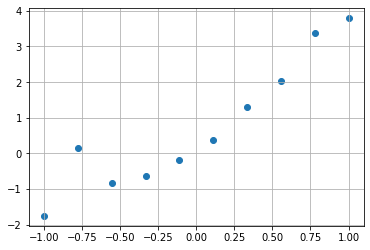

In [5]:
plot_data(x, y)

# Construct linear regression model

In [6]:
model_config = {
    "D": 1,
}

model_hyperparameters = {
    "outputsigma": torch.tensor(.25),
}

model = LinearRegressionModel(train_sigma=False, config=model_config, hyperparameters=model_hyperparameters)

q = MultivariateGaussianDistribution(
    nat_params={
        "np1": torch.zeros(model_config["D"]+1),
        "np2": -0.5 * torch.eye(model_config["D"]+1)
    }
)

/homes/mojb2/Thesis/GI-PVI/venv/lib/python3.7/site-packages/pvi/models/linear_regression.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.hyperparameters["outputsigma"]).log())


/homes/mojb2/Thesis/GI-PVI/venv/lib/python3.7/site-packages/pvi/models/linear_regression.py:87: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  q.nat_params["np1"].unsqueeze(-1), prec)[0].squeeze(-1)
/homes/mojb2/Thesis/GI-PVI/venv/lib/python3.7/site-packages/pvi/utils/psd_utils.py:91: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A)

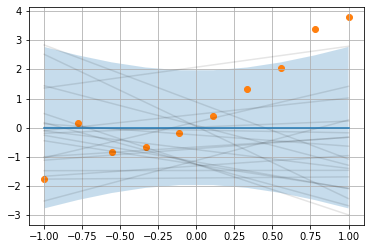

In [7]:
plot_results(x, y, model, q)

# Fit data

In [8]:
t = MultivariateGaussianFactor(
    nat_params={
        "np1": torch.zeros(model.config["D"]+1),
        "np2": 0. * torch.eye(model.config["D"]+1),
    }
)

In [9]:
client_config = {
    "epochs": 1000,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 1e-2},
}


# Construct client.
client = Client(data=data, model=model, t=t, config=client_config)

## Without optimising model (hyper-)parameters

In [10]:
q_new, t_new = client.update_q(q)

In [11]:
type(q_new) == client.model.conjugate_family

True

/homes/mojb2/Thesis/GI-PVI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app


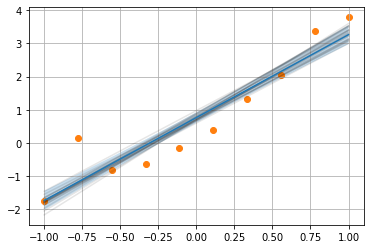

In [12]:
plot_results(x, y, client.model, q_new)